# Intro

## Premise
The issue is always the same: is everything we are doing correct?  
The fact that there is a non trivial superposition between Witten's review and all our documents is suspect...

## Standard modules

In [1]:
import os, sys
import pathlib
import requests

In [2]:
import numpy as np

In [3]:
from tqdm.auto import tqdm, trange

In [4]:
from sentence_transformers import util

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1

In [24]:
from sklearn.decomposition import PCA

## Personal modules

In [6]:
from toolbox.updater import time_is_now

In [7]:
from file2text import file2text

In [8]:
from first_rough_cleaning import first_text_cleaner

In [9]:
from file_handler import *

In [10]:
from jina4lote import jina4lote

/home/sarawalk/sdgs_py38/lib/python3.8/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


## Folders

In [11]:
VECTOR_FOLDER='./NewProcessedData/vectors/'

In [12]:
BENCHMARK_FOLDER='./NewProcessedData/benchmarks/'

In [113]:
PCA_CENTR_VECTOR_FOLDER='./NewProcessedData/pca_centr_vectors/'

## Reports' vectors

In [13]:
vecfiles=os.listdir(VECTOR_FOLDER)

In [14]:
vecfiles.sort()

## Witten's vector

In [15]:
wittenvecfile=[file for file in os.listdir(BENCHMARK_FOLDER) if file.startswith('Witten') and file.endswith('.txt')][0]

In [16]:
wittenvec=np.genfromtxt(BENCHMARK_FOLDER+wittenvecfile)

# Mean vector

## Calculation

In [17]:
for i, vecfile in enumerate(tqdm(vecfiles)):
    if i==0:
        mean_vec=np.genfromtxt(VECTOR_FOLDER+vecfile)
    else:
        mean_vec+=np.genfromtxt(VECTOR_FOLDER+vecfile)
mean_vec/=len(vecfiles)

  0%|          | 0/575 [00:00<?, ?it/s]

## Witten is quite close to be mean

In [18]:
util.cos_sim(wittenvec, mean_vec)

tensor([[0.8199]], dtype=torch.float64)

...which is nice!

In [19]:
cos_sims=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    vec=np.genfromtxt(VECTOR_FOLDER+vecfile)
    cos_sim=float(util.cos_sim(wittenvec, vec-mean_vec))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    cos_sims[i]=cos_sim

  0%|          | 0/575 [00:00<?, ?it/s]

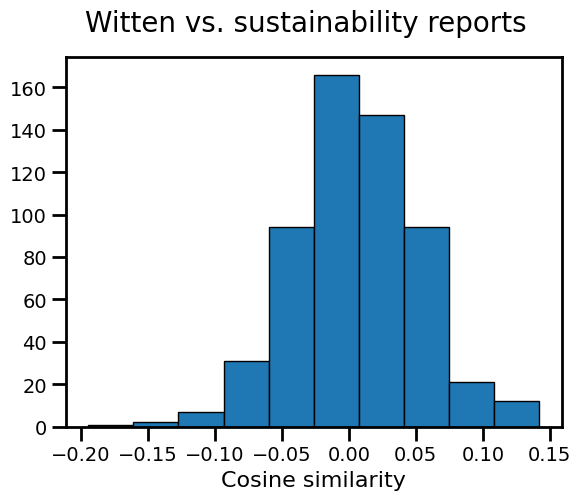

In [20]:
plt.hist(cos_sims, edgecolor='black')
plt.suptitle('Witten vs. sustainability reports', fontsize=20)
plt.xlabel('Cosine similarity', fontsize=16)
plt.show()

That's much better. 

# PCA

The dimension fo the embedding is the same for all vectors:

In [21]:
len(wittenvec)

768

In [22]:
vecs=np.zeros((len(vecfiles), len(wittenvec)))

In [23]:
for i, vecfile in enumerate(tqdm(vecfiles)):
    vec=np.genfromtxt(VECTOR_FOLDER+vecfile)
    vecs[i]=vec

  0%|          | 0/575 [00:00<?, ?it/s]

## Taking everything

In [76]:
pca = PCA()
new_vecs=pca.fit_transform(vecs)

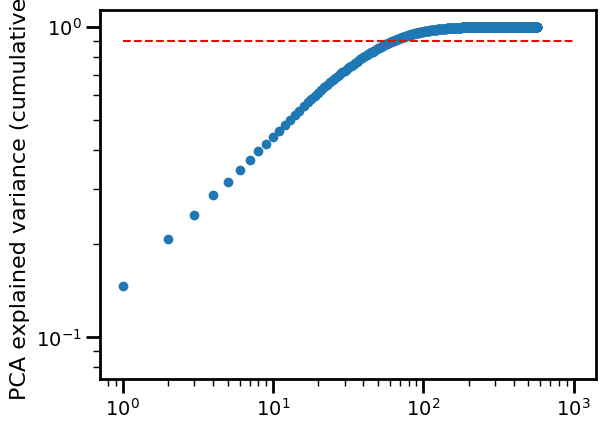

In [77]:
plt.scatter(np.arange(len(vecfiles)), np.cumsum(pca.explained_variance_ratio_))
plt.hlines(0.90, 1, 1000, ls='--', color='red')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PCA explained variance (cumulative)', fontsize=16)
plt.show()

In [80]:
np.where(np.cumsum(pca.explained_variance_ratio_)<=.90)[0][-1]

63

In [78]:
np.where(np.cumsum(pca.explained_variance_ratio_)<=.95)[0][-1]

87

In [79]:
np.where(np.cumsum(pca.explained_variance_ratio_)<=.99)[0][-1]

160

## Dimensional reduction

In [81]:
pca = PCA(n_components=63)
new_vecs=pca.fit_transform(vecs)

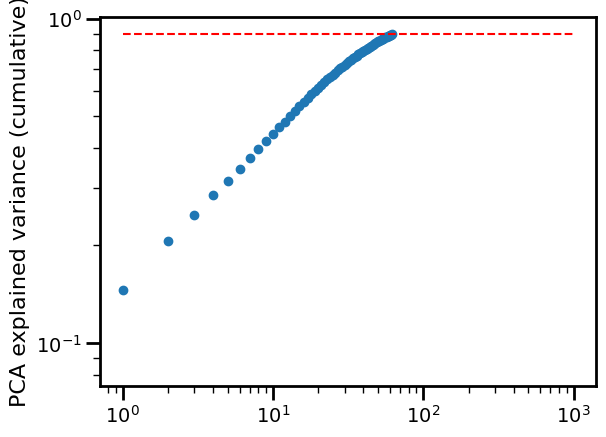

In [82]:
plt.scatter(np.arange(63), np.cumsum(pca.explained_variance_ratio_))
plt.hlines(0.90, 1, 1000, ls='--', color='red')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PCA explained variance (cumulative)', fontsize=16)
plt.show()

## Check with Witten

In [88]:
wittenvec.T

array([-3.02811189e-02, -3.81932141e-02,  5.04839207e-02, -8.00098124e-03,
       -3.53469865e-02, -3.23630692e-03, -6.81020060e-03, -2.89417768e-02,
        5.92756829e-02,  8.08559115e-03, -1.55386966e-02, -9.66650055e-03,
       -3.56608460e-02, -6.64788847e-03, -4.35948768e-02,  7.00658821e-02,
       -1.15720409e-02,  6.07534971e-03,  6.03255241e-03, -9.20716491e-03,
       -1.40867959e-02, -3.93993677e-02, -3.48379897e-02, -9.90491321e-03,
        2.00452551e-02, -1.42847605e-03,  5.88203656e-02,  2.48458379e-02,
        4.49237034e-02,  3.21563627e-02,  2.96030887e-03, -2.53623230e-02,
       -4.41500462e-02,  1.02410977e-02,  2.29212367e-04, -6.59512065e-02,
       -1.54529956e-02, -1.65040052e-03,  7.72846153e-02,  6.11668911e-02,
       -2.46362986e-02,  5.33290305e-03,  1.44023294e-02,  6.18857648e-02,
       -5.30239550e-02, -9.63267495e-03, -1.90574004e-02,  1.46386031e-02,
       -2.03105476e-02, -4.04475940e-02, -2.31404802e-02, -3.59528446e-02,
        2.79525956e-03, -

In [90]:
new_wittenvec = pca.transform([wittenvec])

In [91]:
pca_cos_sims=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(new_wittenvec, new_vecs[i]))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    pca_cos_sims[i]=cos_sim

  0%|          | 0/575 [00:00<?, ?it/s]

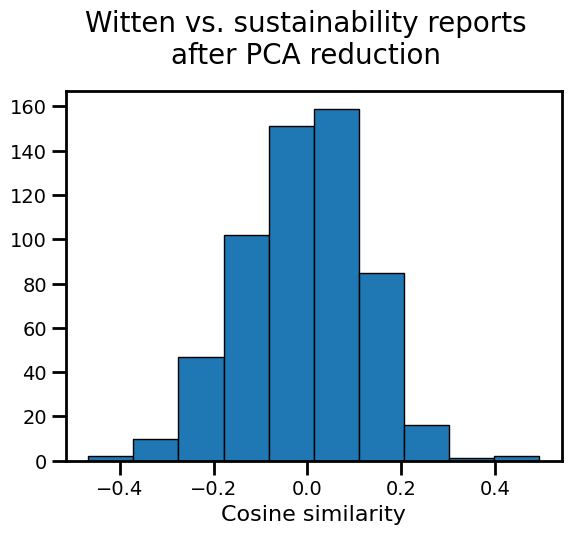

In [95]:
plt.hist(pca_cos_sims, edgecolor='black')
plt.suptitle('Witten vs. sustainability reports\nafter PCA reduction', fontsize=20, y=1.05)
plt.xlabel('Cosine similarity', fontsize=16)
plt.show()

# Mean vector AND PCA

In [96]:
no_mean_vecs=np.zeros((len(vecfiles), len(wittenvec)))

In [97]:
for i, vecfile in enumerate(tqdm(vecfiles)):
    vec=np.genfromtxt(VECTOR_FOLDER+vecfile)-mean_vec
    no_mean_vecs[i]=vec

  0%|          | 0/575 [00:00<?, ?it/s]

## Taking everything

In [98]:
pca = PCA()
new_no_mean_vecs=pca.fit_transform(no_mean_vecs)

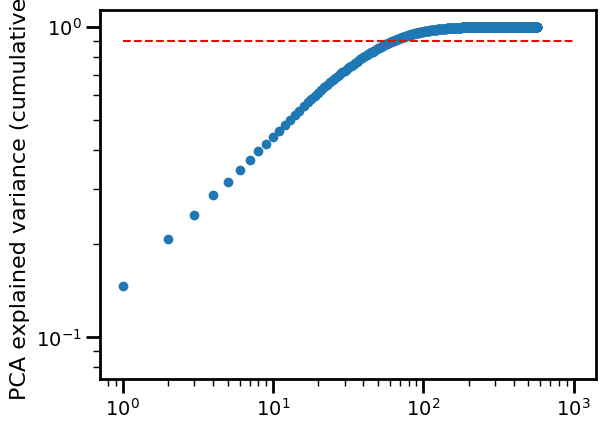

In [99]:
plt.scatter(np.arange(len(vecfiles)), np.cumsum(pca.explained_variance_ratio_))
plt.hlines(0.90, 1, 1000, ls='--', color='red')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PCA explained variance (cumulative)', fontsize=16)
plt.show()

In [100]:
np.where(np.cumsum(pca.explained_variance_ratio_)<=.90)[0][-1]

63

In [101]:
np.where(np.cumsum(pca.explained_variance_ratio_)<=.95)[0][-1]

87

In [102]:
np.where(np.cumsum(pca.explained_variance_ratio_)<=.99)[0][-1]

160

## Dimensional reduction

In [103]:
pca = PCA(n_components=63)
new_no_mean_vecs=pca.fit_transform(no_mean_vecs)

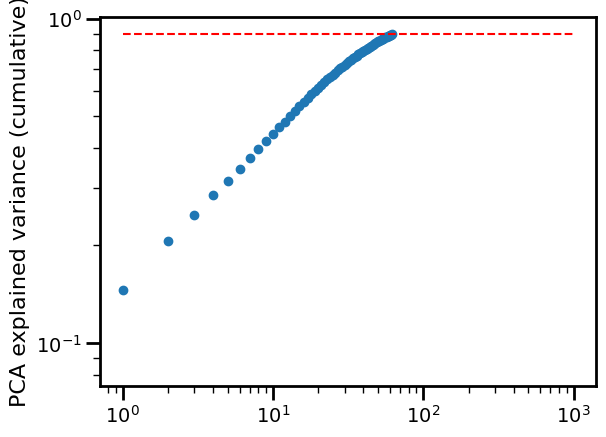

In [104]:
plt.scatter(np.arange(63), np.cumsum(pca.explained_variance_ratio_))
plt.hlines(0.90, 1, 1000, ls='--', color='red')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('PCA explained variance (cumulative)', fontsize=16)
plt.show()

## Check with Witten

In [105]:
new_wittenvec = pca.transform([wittenvec])

In [131]:
pca_cos_sims_w=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(new_wittenvec, new_no_mean_vecs[i]))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    pca_cos_sims_w[i]=cos_sim

  0%|          | 0/575 [00:00<?, ?it/s]

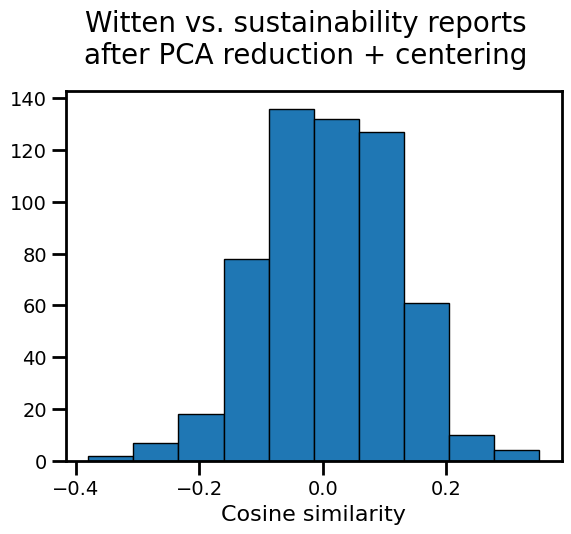

In [132]:
plt.hist(pca_cos_sims_w, edgecolor='black')
plt.suptitle('Witten vs. sustainability reports\nafter PCA reduction + centering', fontsize=20, y=1.05)
plt.xlabel('Cosine similarity', fontsize=16)
plt.show()

In [133]:
np.mean(pca_cos_sims_w), np.std(pca_cos_sims_w)

(0.010612148579943878, 0.10796481589063854)

## Save transformed vectors

### Reports

In [111]:
vecfiles[0]

'2015_01_ANGLO_AMERICAN_PLC.txt'

In [114]:
for i, vecfile in enumerate(tqdm(vecfiles)):
    np.savetxt(PCA_CENTR_VECTOR_FOLDER+vecfile, new_no_mean_vecs[i])

  0%|          | 0/575 [00:00<?, ?it/s]

### Benchmarks

In [116]:
benchmark_files=[file for file in os.listdir(BENCHMARK_FOLDER) if file.endswith('.txt')]
for file in tqdm(benchmark_files):
    bench_vec=np.genfromtxt(BENCHMARK_FOLDER+file)
    new_bench_vec=pca.transform([bench_vec])
    np.savetxt(PCA_CENTR_VECTOR_FOLDER+file, new_bench_vec)

  0%|          | 0/19 [00:00<?, ?it/s]

## Check with SDGs

### Goals' vectors

In [125]:
goalvecfiles=[file for file in os.listdir(PCA_CENTR_VECTOR_FOLDER) if file.startswith('Goal') and file.endswith('.txt')]

In [126]:
goalvecfiles.sort()

In [127]:
goalvecfiles

['Goal-10-Fast-Facts.txt',
 'Goal-11_Fast-Facts.txt',
 'Goal-12_Fast-Facts.txt',
 'Goal-13_Fast-Facts.txt',
 'Goal-14_Fast-Facts.txt',
 'Goal-15-Fast-Facts.txt',
 'Goal-16-Fast-Facts.txt',
 'Goal-17-Fast-Facts.txt',
 'Goal-1_Fast-Facts.txt',
 'Goal-2_Fast-Facts.txt',
 'Goal-3_Fast-Facts.txt',
 'Goal-4_Fast-Facts.txt',
 'Goal-5_Fast-Facts.txt',
 'Goal-6_Fast-Facts.txt',
 'Goal-7_Fast-Facts.txt',
 'Goal-8_Fast-Facts.txt',
 'Goal-9-Fast-Facts.txt',
 'Goal-Fast-Facts.txt']

In [128]:
goalvecs=[np.genfromtxt(PCA_CENTR_VECTOR_FOLDER+goalvecfile) for goalvecfile in goalvecfiles]

### Cosine similarity

In [129]:
pca_cos_sims=np.zeros(len(vecfiles))
for i, vecfile in enumerate(tqdm(vecfiles)):
    cos_sim=float(util.cos_sim(goalvecs[-1], new_no_mean_vecs[i]))
    #print(f'{vecfile:})\tcos={cos_sim:.3f}')
    pca_cos_sims[i]=cos_sim

  0%|          | 0/575 [00:00<?, ?it/s]

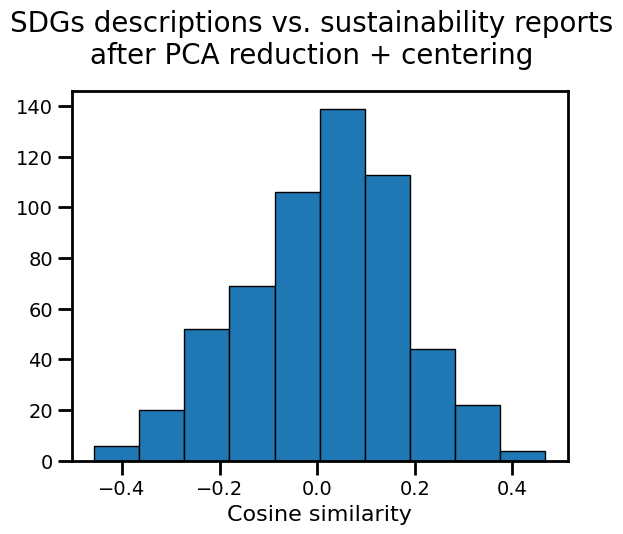

In [135]:
plt.hist(pca_cos_sims, edgecolor='black')
plt.suptitle('SDGs descriptions vs. sustainability reports\nafter PCA reduction + centering', fontsize=20, y=1.05)
plt.xlabel('Cosine similarity', fontsize=16)
plt.show()

In [136]:
np.mean(pca_cos_sims), np.std(pca_cos_sims)

(0.015709916887901864, 0.16252681229109625)